Epoch 1/200, Train Loss: 0.4594, Train MAE: 0.5581, Validation Loss: 0.3892, Validation MAE: 0.5095, Validation R-squared: -4.8185, MAE = 0.5312331914901733, RMSE = 0.6374548077583313,
Epoch 2/200, Train Loss: 0.3802, Train MAE: 0.5036, Validation Loss: 0.3461, Validation MAE: 0.4843, Validation R-squared: -4.0887, MAE = 0.5026175379753113, RMSE = 0.5983138680458069,
Epoch 3/200, Train Loss: 0.3141, Train MAE: 0.4549, Validation Loss: 0.3021, Validation MAE: 0.4537, Validation R-squared: -3.3831, MAE = 0.46882811188697815, RMSE = 0.5560358166694641,
Epoch 4/200, Train Loss: 0.2620, Train MAE: 0.4136, Validation Loss: 0.2556, Validation MAE: 0.4163, Validation R-squared: -2.6583, MAE = 0.4286448657512665, RMSE = 0.5085790753364563,
Epoch 5/200, Train Loss: 0.2207, Train MAE: 0.3783, Validation Loss: 0.2080, Validation MAE: 0.3742, Validation R-squared: -1.9098, MAE = 0.38080283999443054, RMSE = 0.4550614655017853,
Epoch 6/200, Train Loss: 0.1904, Train MAE: 0.3496, Validation Loss: 0.16

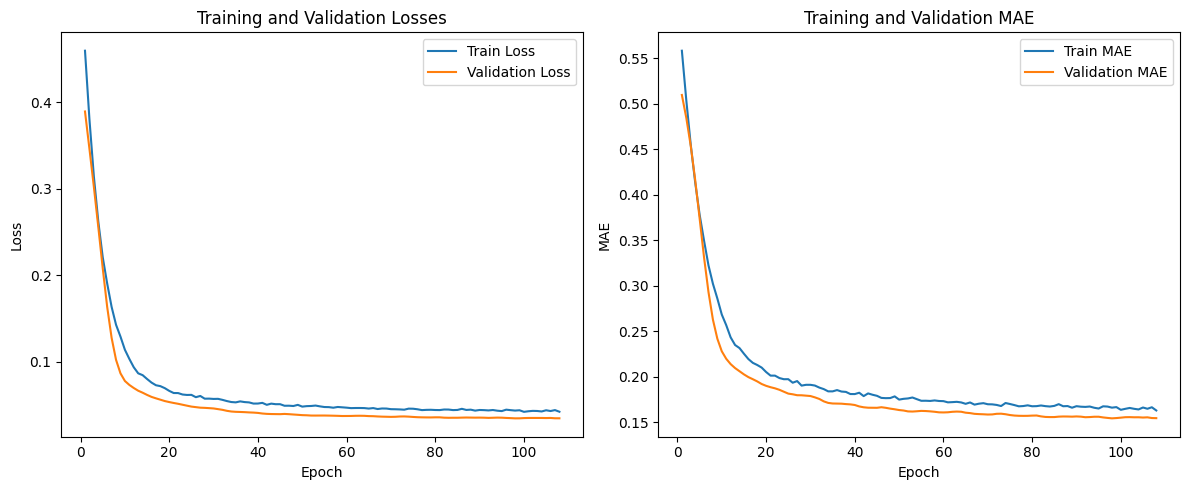

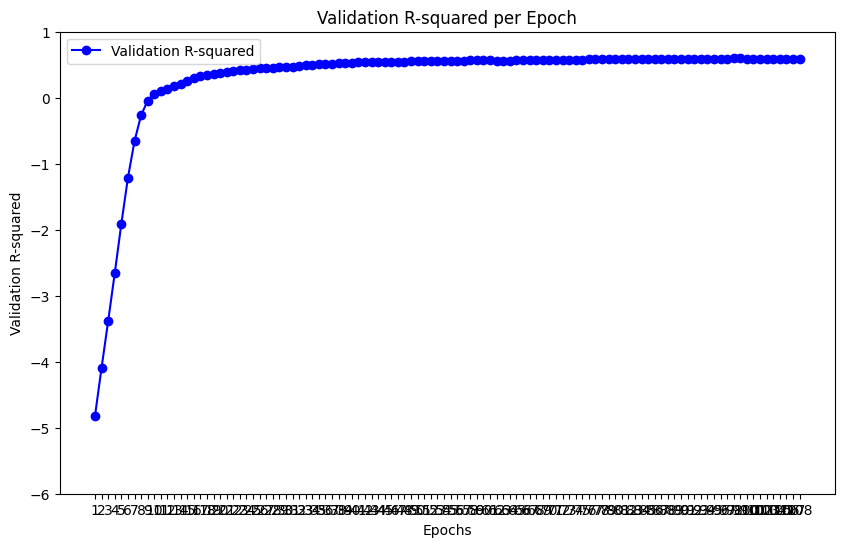

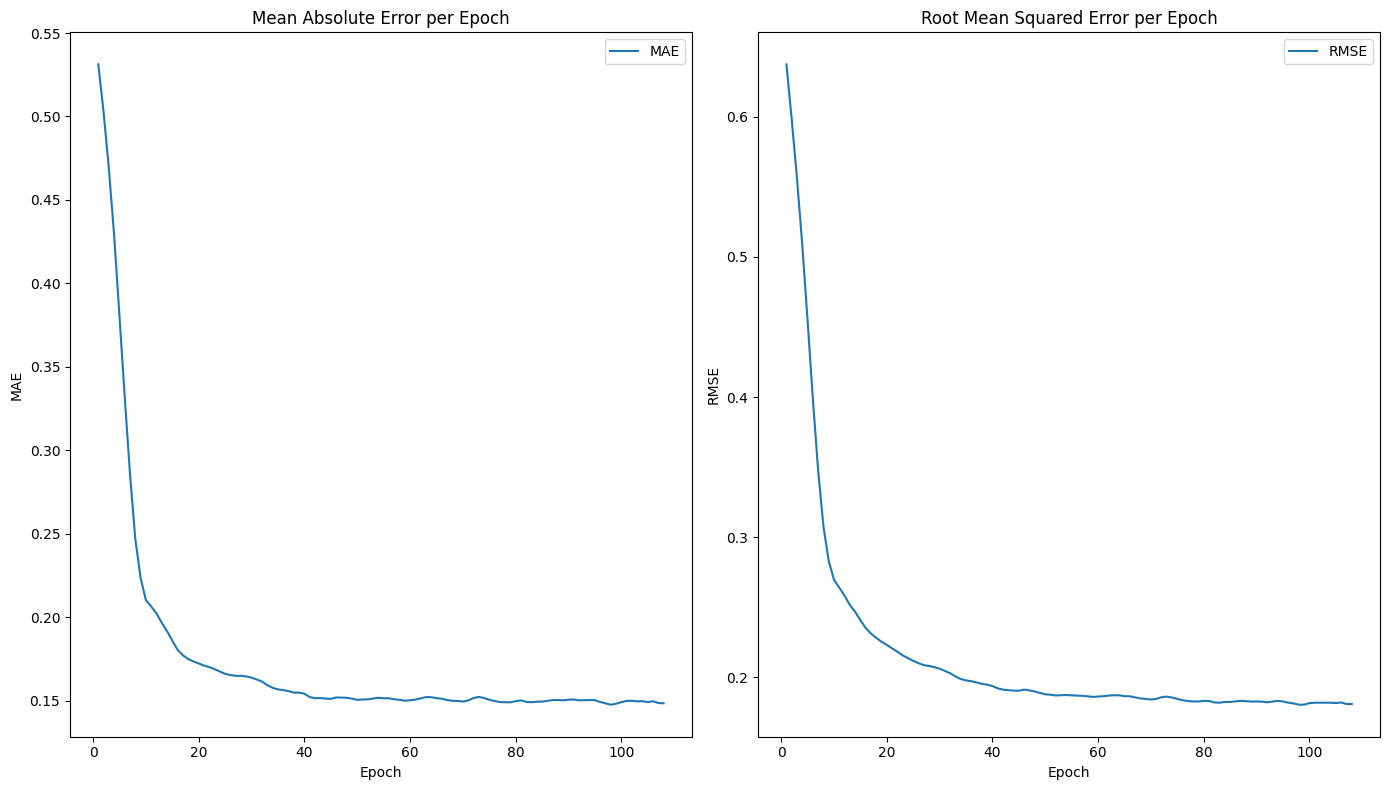

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, r2_score

# Vytvorenie datasetu pre pytorch
class LotteryDataset(Dataset):
    def __init__(self, X, y):
        # Prevedenie vstupov a cieľov na torch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        # Vráti dĺžku datasetu
        return len(self.X)

    def __getitem__(self, idx):
        # Vráti konkrétny vzor podľa indexu
        return self.X[idx], self.y[idx]

# Definícia neurónovej siete
class LotteryModel(nn.Module):
    def __init__(self):
        super(LotteryModel, self).__init__()        
        # Vstupná lineárna vrstva (18 vstupov na 10 neurónov)
        self.fc6 = nn.Linear(18, 10)
        # Batch Normalization (normalizuje vstupy pre stabilnejší a rýchlejší tréning)
        self.bn6 = nn.BatchNorm1d(10) 
        # Dropout (regularizácia - náhodne vynuluje niektoré neuróny)
        self.dropout6 = nn.Dropout(0.1)
        # LeakyReLU aktivácia (rieši problém s "mŕtvymi" neurónmi v ReLU)
        self.leaky_relu6 = nn.LeakyReLU(negative_slope=0.01)
        
        # Ďalšia lineárna vrstva (10 vstupov na 15 neurónov)
        self.fc7 = nn.Linear(10, 15)

    def forward(self, x):
        # Prechod dát cez prvú vrstvu s aktiváciou, batch norm. a dropout
        x = self.leaky_relu6(self.bn6(self.fc6(x)))
        x = self.dropout6(x)
        
        # Prechod dát cez druhú vrstvu (lineárna vrstva)
        x = self.fc7(x)
        
        return x

# Definícia MAE (Mean Absolute Error) metriky
def mae_loss(output, target):
    return torch.mean(torch.abs(output - target))

# Definícia RMSE (Root Mean Squared Error) metriky
def rmse_loss(output, target):
    return torch.sqrt(torch.mean((output - target) ** 2))

# Funkcia na tréning modelu
def train_model(model: nn.Module, 
                train_loader: DataLoader, 
                test_loader: DataLoader, 
                criterion: nn.Module, 
                optimizer, 
                num_epochs: int = 200, 
                device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
                patience: int = 10):
    
    # Inicializácia zariadenia (GPU ak je dostupné, inak CPU)
    torch.manual_seed(42)
    model.to(device)
    
    # Sledovanie strát a metrík počas tréningu a validácie
    train_losses, val_losses, train_maes, val_maes, validation_r2s, mae_scores, rmse_scores = [], [], [], [], [], [], []
    best_val_loss = float('inf')
    best_model = None
    no_improvement_count = 0

    for epoch in range(num_epochs):
        # Tréningová fáza modelu
        model.train()
        train_loss, train_mae_sum, train_total = 0, 0, 0

        for inputs, targets in train_loader:
            # Presun dát na zariadenie (GPU/CPU)
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Predikcia modelu
            outputs = model(inputs)
            # Výpočet straty (MSE)
            loss = criterion(outputs, targets)

            # Optimalizácia (backpropagation)
            optimizer.zero_grad()  # Nulovanie gradientov
            loss.backward()        # Výpočet gradientov
            optimizer.step()       # Aktualizácia váh
            
            # Akumulácia tréningovej straty a MAE
            train_loss += loss.item()
            train_mae_sum += nn.L1Loss()(outputs, targets).item() * targets.size(0)
            train_total += targets.size(0)
        
        # Priemerná strata a MAE na konci epochy
        train_loss /= len(train_loader)
        train_mae = train_mae_sum / train_total
        train_losses.append(train_loss)
        train_maes.append(train_mae)

        # Validačná fáza modelu
        model.eval()
        val_loss, val_mae_sum, val_total = 0, 0, 0
        
        # Validačná fáza bez výpočtu gradientov
        with torch.inference_mode():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Predikcia modelu na validačných dátach
                outputs = model(inputs)
                
                # Výpočet validačnej straty
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                # Akumulácia validačnej MAE
                val_mae_sum += nn.L1Loss()(outputs, targets).item() * targets.size(0)
                val_total += targets.size(0)

                # Výpočet MAE a RMSE
                mae = mae_loss(outputs, targets)
                rmse = rmse_loss(outputs, targets)

                # Inverse transform na pôvodné hodnoty (pre výpočet R2)
                y_true = scaler_y.inverse_transform(targets.cpu().numpy())
                y_pred = scaler_y.inverse_transform(outputs.detach().cpu().numpy())
                val_r2 = r2_score(y_true, y_pred)

        # Priemerná validačná strata a MAE
        val_loss /= len(test_loader)
        val_mae = val_mae_sum / val_total
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        # Záznam metrík
        mae_scores.append(mae.item())
        rmse_scores.append(rmse.item())
        validation_r2s.append(val_r2)
        
        # Tlač výsledkov pre aktuálnu epochu
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, '
              f'Train MAE: {train_mae:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Validation MAE: {val_mae:.4f}, Validation R-squared: {val_r2:.4f}, '
              f'MAE = {mae.item()}, RMSE = {rmse.item()},'
        )
        
        # Early stopping ak sa nezlepšuje validačná strata
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Načítaj najlepší model
    model.load_state_dict(best_model)
    
    return train_losses, val_losses, train_maes, val_maes, validation_r2s, mae_scores, rmse_scores

# Funkcia na vykreslenie kriviek učenia (Loss, MAE, R2)
def plot_learning_curves(train_losses, val_losses, train_maes, val_maes, validation_r2s, mae_scores, rmse_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    # Graf tréningových a validačných strát
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    
    # Graf tréningových a validačných MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_maes, label='Train MAE')
    plt.plot(epochs, val_maes, label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE')
    plt.legend()
    
    plt.tight_layout()

    # Graf validačného R-squared
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, validation_r2s, marker='o', linestyle='-', color='b', label='Validation R-squared')
    
    plt.title('Validation R-squared per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Validation R-squared')
    plt.xticks(epochs)
    plt.yticks([round(x, 2) for x in plt.yticks()[0]])
    
    plt.legend()

    plt.figure(figsize=(14, 8))
    
    # Graf pre MAE
    plt.subplot(1, 2, 1)
    plt.plot(epochs, mae_scores, label='MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Mean Absolute Error per Epoch')
    plt.legend()
    
    # Graf pre RMSE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, rmse_scores, label='RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Root Mean Squared Error per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()




# Načítanie dát zo súboru CSV do DataFrame
data = pd.read_csv('win_num.csv')

# Výber vstupných premenných (X) z dát
X = data[['year', 'month', 'day', 'final_six_figure_odds', 'one_move_1_num', 'one_move_2_num', 
          'one_move_3_num', 'one_move_4_num', 'one_move_5_num', 'one_move_6_num', 'one_move_7_num', 
          'two_move_1_num', 'two_move_2_num', 'two_move_3_num', 'two_move_4_num', 'two_move_5_num', 
          'two_move_6_num', 'two_move_7_num']]

# Výber cieľových premenných (y) z dát
y = data[['final_six_figure_odds', 'one_move_1_num', 'one_move_2_num', 'one_move_3_num', 
          'one_move_4_num', 'one_move_5_num', 'one_move_6_num', 'one_move_7_num', 
          'two_move_1_num', 'two_move_2_num', 'two_move_3_num', 'two_move_4_num', 
          'two_move_5_num', 'two_move_6_num', 'two_move_7_num']]

# Prevedenie všetkých hodnôt v DataFrame 'X' na numerické hodnoty
# Nepoužiteľné hodnoty (napr. nečíselné hodnoty) sú prevedené na NaN (Not a Number)
X = data.apply(pd.to_numeric, errors='coerce')

# Odstránenie riadkov a stĺpcov, ktoré obsahujú NaN hodnoty
X = X.dropna().dropna(axis=1)

# Rovnaký postup pre cieľové premenné (y)
y = y.apply(pd.to_numeric, errors='coerce')
y = y.dropna().dropna(axis=1)

# Rozdelenie dát na tréningovú (80%) a testovaciu (20%) sadu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializácia MinMaxScaler pre normalizáciu vstupných a výstupných dát
# Normalizuje hodnoty medzi 0 a 1
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fitransform na tréningovú sadu X (aplikuje normalizáciu)
X_train = scaler_X.fit_transform(X_train)
# Transform na testovaciu sadu X (aplikuje rovnakú normalizáciu ako na tréningové dáta)
X_test = scaler_X.transform(X_test)

# Fitransform na tréningovú sadu y (normalizácia výstupov)
y_train = scaler_y.fit_transform(y_train)
# Transform na testovaciu sadu y
y_test = scaler_y.transform(y_test)

# Vytvorenie datasetu pre PyTorch (vstupy a výstupy zabalené do custom Dataset triedy)
train_dataset = LotteryDataset(X_train, y_train)
test_dataset = LotteryDataset(X_test, y_test)

# Vytvorenie DataLoaderov (na dávkové spracovanie dát počas tréningu)
# train_loader: dávkuje tréningové dáta v šaržiach po 148 vzoriek, so zamiešaním
train_loader = DataLoader(train_dataset, batch_size=148, shuffle=True)
# test_loader: dávkuje testovacie dáta v šaržiach po 168 vzoriek, bez zamiešania
test_loader = DataLoader(test_dataset, batch_size=168, shuffle=False)

# Inicializácia modelu (neurónová sieť, ktorú sme definovali)
model = LotteryModel()

# Inicializácia stratovej funkcie (Mean Squared Error - MSE)
criterion = nn.MSELoss()

# Inicializácia optimalizátora (Adam optimizer s learning rate 0.003)
# weight_decay: L2 regularizácia, ktorá pridáva trest za veľké váhy
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-3)

# Trénovanie modelu
train_losses, val_losses, train_maes, val_maes, validation_r2s, mae_scores, rmse_scores = train_model(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    patience=10  # Early stopping - zastaví tréning, ak sa validačná strata nezlepšuje po 10 epochách
)

# Vykreslenie kriviek učenia (strata, MAE, RMSE a R-squared pre tréning a validáciu)
plot_learning_curves(train_losses, val_losses, train_maes, val_maes, validation_r2s, mae_scores, rmse_scores)


In [24]:
# pravdepodobnosť, že konkrétne číslo sa objaví
new_data = pd.DataFrame({
    'year': [2024, 2024, 2024, 2024, 2024],
    'month': [9, 9, 9, 9, 9],
    'day': [6, 8, 11, 15, 18],
    'final_six_figure_odds': [745349, 556943, 760879, 985421, 456554,],
    'one_move_1_num': [25, 29, 30, 44, 13],
    'one_move_2_num': [44, 47, 33, 22, 31],
    'one_move_3_num': [41, 41, 40, 41, 6],
    'one_move_4_num': [8, 45, 36, 18, 4],
    'one_move_5_num': [29, 19, 4, 11, 22],
    'one_move_6_num': [28, 23, 47, 19, 44],
    'one_move_7_num': [49, 7, 20, 9, 10],
    
    'two_move_1_num': [44, 49, 48, 4, 7],
    'two_move_2_num': [4, 42, 14, 19, 14],
    'two_move_3_num': [8, 37, 6, 14, 29],
    'two_move_4_num': [3, 8, 5, 48, 4],
    'two_move_5_num': [34, 12, 20, 31, 36],
    'two_move_6_num': [45, 11, 24, 12, 31],
    'two_move_7_num': [28, 10, 22, 41, 18],
})

new_data_scaled = scaler_X.fit_transform(new_data)
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)

      
with torch.inference_mode():
    model.eval()
    for inputs, targets in test_loader:
        predict = model(new_data_tensor)

        y_predict = scaler_y.inverse_transform(predict)
        predictions = y_predict.round().astype(int)
        
for pred in predictions:
    print("Šesťmiestne číslo:", pred[:1])
    print("1. Tah:", pred[1:8])
    print("2. Tah:", pred[8:18])
    print()

Šesťmiestne číslo: [675624]
1. Tah: [37 34 30 17 19 14 41]
2. Tah: [28 13 24 20 28 42 35]

Šesťmiestne číslo: [361045]
1. Tah: [33 41 47 29 11 17 10]
2. Tah: [39 39 28 31 14 14 19]

Šesťmiestne číslo: [556029]
1. Tah: [24 21 39 28  3 40 19]
2. Tah: [37 10 12 20  8 26 20]

Šesťmiestne číslo: [757704]
1. Tah: [40  5 57 30 29 14 17]
2. Tah: [ 9 24 25 31 28 17 32]

Šesťmiestne číslo: [325115]
1. Tah: [16 33 10 21 26 32 17]
2. Tah: [15 11 31 10 30 24 19]

